This file was the first attempt of using machine learning on Ex-vivo dataset. 
However, this was coded in a very early point of the project and many changes to how machine learning have been conducted can be seen in the 'scripts' folder.

# Loading Data

In [1]:
import os
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal.windows import tukey
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from sklearn.decomposition import PCA

In [2]:
# Loading ex-vivo data
path_to_data = "Data\\Ex-Vivo\\"
files = os.listdir(path_to_data)

# Removing readme
files.remove("READ_ME.txt")

data = []

for file in files:
    with open(path_to_data + file, 'rb') as f:
        data.append(pickle.load(f))

# sorting data based on date

for d in data:
    timestamp = d['time']
    d['date'] = datetime.fromisoformat(timestamp)

data = sorted(data, key=lambda x: x['date'])

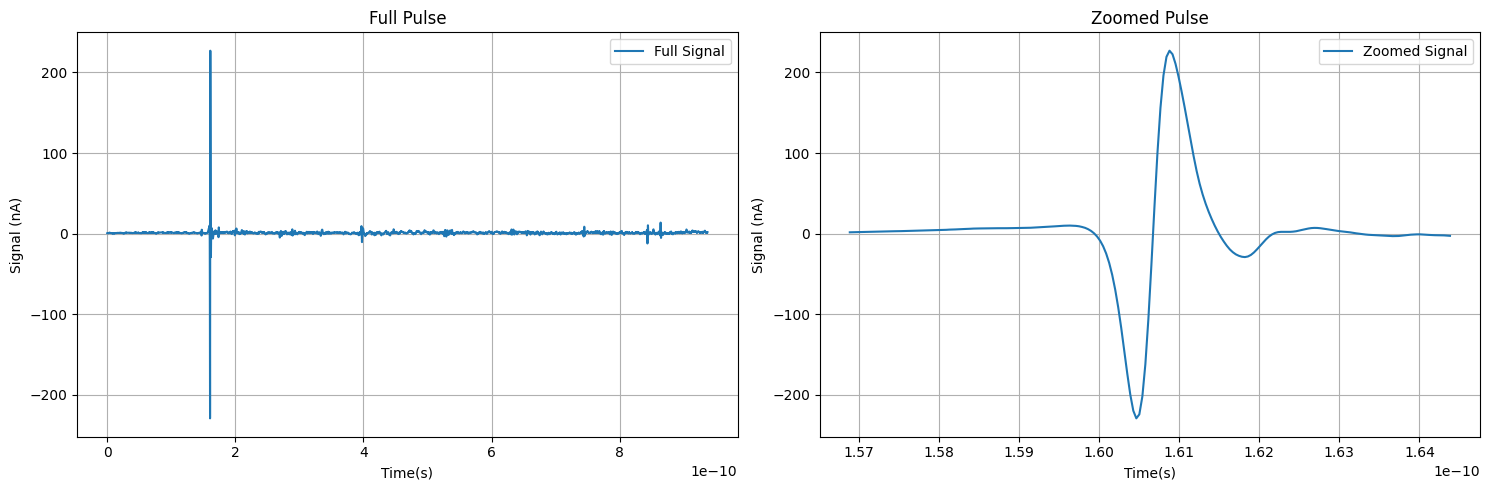

In [3]:
x = data[4]['scan'][0]['forward_scan']['time']
y = data[4]['scan'][0]['forward_scan']['signal']

min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 100
zoom_end = middle_index + 100

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Full Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Full Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Zoomed Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


reason for noise:


# Preprocessing

List of preprocessing:
- Manually Fixing errors in data based on information from READ_ME.txt
- Tukey window to isolate main pulse and remove noise from reflections etc.
- Fourier transform and focusing on amplitude only for now. phase will be affected by the misalignment. (Look into how to fix this)
- Removing system error by dividing with air reference
- Removing sample 'error' by dividing with bare sample
- Cutting out noisy part of signal

In [4]:
# Fixing labeling errors

data[51]['samplematrix'] = 'sample 7 PBS'
data[51]['conc'] = 0.0

data[52]['samplematrix'] = 'sample 8 g/PBS'
data[52]['conc'] = 2.5

data[53]['samplematrix'] = 'sample 6 g/PBS'
data[53]['conc'] = 2.5


# Fixing issue with sample ids due to multiple days

for d in data:
    d['samplematrix_fixed'] = d['samplematrix']

for d in data[37:]:
    values = d['samplematrix'].split()
    if len(values) > 1:
        id = int(values[1])
        new_id = id+18
        new_samplematrix = values[0] + " " + str(new_id) + " " + values[2]
        d['samplematrix_fixed'] = new_samplematrix



In [5]:
# Removing air and NC as these are irrelevant for our purpose
data = [d for d in data if not d['samplematrix_fixed'] == 'air']

ids_to_remove = []

for d in data:
    values = d['samplematrix_fixed'].split()
    if values[2] == 'NC':
        ids_to_remove.append(values[1])

data = [d for d in data if not d['samplematrix_fixed'].split()[1] in ids_to_remove]

In [6]:
# Applying Tukey window to all signals

window_size = 150
alpha = 0.8

for d in data:
    for scan in d['scan']:
        y = scan['forward_scan']['signal']

        min_index = np.argmin(y)
        max_index = np.argmax(y)
        middle_index = math.floor((min_index+max_index)/2)

        window_start = middle_index - window_size
        window_end = middle_index + window_size

        window = tukey(window_end-window_start, alpha = alpha)
        windowed_signal = y[window_start: window_end] * window
        y = np.zeros(len(y), dtype=float)
        y[window_start: window_end] = windowed_signal

        scan['signal_tukey'] = y

    if d['ref'] is None:
        continue

    for scan in d['ref']:
        y = scan['forward_scan']['signal']

        min_index = np.argmin(y)
        max_index = np.argmax(y)
        middle_index = math.floor((min_index+max_index)/2)

        window_start = middle_index - window_size
        window_end = middle_index + window_size

        window = tukey(window_end-window_start, alpha = alpha)
        windowed_signal = y[window_start: window_end] * window
        y = np.zeros(len(y), dtype=float)
        y[window_start: window_end] = windowed_signal

        scan['signal_tukey'] = y


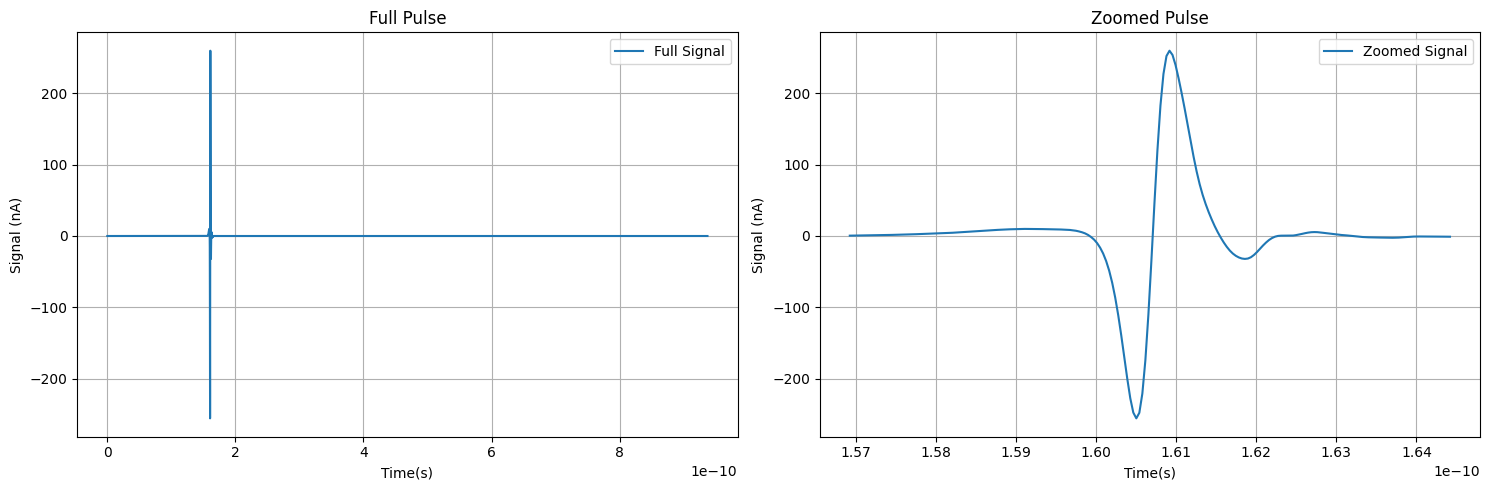

In [7]:
# Plotting effect of tukey window
x = data[4]['scan'][0]['forward_scan']['time']
y = data[4]['scan'][0]['signal_tukey']

min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 100
zoom_end = middle_index + 100

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Full Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Full Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Zoomed Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Applying FFT to all signals

for d in data:
    for scan in d['scan']:
        x = scan['forward_scan']['time']
        y = scan['signal_tukey']

        fft_result = np.fft.fft(y)

        amplitudes = np.abs(fft_result)
            
        amplitudes = amplitudes / len(y)

        # FFT output is symmetric, so taking just the first half
        half_point = len(y) // 2
        frequencies = np.fft.fftfreq(len(y), d=x[1] - x[0])[:half_point]
        frequencies = frequencies * (10**(-12))
        amplitudes = amplitudes[:half_point]
        scan['amplitudes'] = amplitudes
        scan['frequencies'] = frequencies

    if d['ref'] is None:
        continue

    for scan in d['ref']:
        x = scan['forward_scan']['time']
        y = scan['signal_tukey']

        fft_result = np.fft.fft(y)

        # Extracting amplitudes (magnitudes of the complex numbers)
        amplitudes = np.abs(fft_result)
            
        # Normalizing the amplitudes by the number of samples to get the correct scale
        amplitudes = amplitudes / len(y)

        half_point = len(y) // 2
        frequencies = np.fft.fftfreq(len(y), d=x[1] - x[0])[:half_point]
        frequencies = frequencies * (10**(-12))
        amplitudes = amplitudes[:half_point]
        scan['amplitudes'] = amplitudes
        scan['frequencies'] = frequencies

In [9]:
# Applying FFT to all signals

for d in data:
    for scan in d['scan']:
        x = scan['forward_scan']['time']
        y = scan['forward_scan']['signal']

        fft_result = np.fft.fft(y)

        amplitudes = np.abs(fft_result)
            
        amplitudes = amplitudes / len(y)

        # FFT output is symmetric, so taking just the first half
        half_point = len(y) // 2
        frequencies = np.fft.fftfreq(len(y), d=x[1] - x[0])[:half_point]
        frequencies = frequencies * (10**(-12))
        amplitudes = amplitudes[:half_point]
        scan['amplitudes_no_tukey'] = amplitudes
        scan['frequencies_no_tukey'] = frequencies

    if d['ref'] is None:
        continue

    for scan in d['ref']:
        x = scan['forward_scan']['time']
        y = scan['forward_scan']['signal']

        fft_result = np.fft.fft(y)

        # Extracting amplitudes (magnitudes of the complex numbers)
        amplitudes = np.abs(fft_result)
            
        # Normalizing the amplitudes by the number of samples to get the correct scale
        amplitudes = amplitudes / len(y)

        half_point = len(y) // 2
        frequencies = np.fft.fftfreq(len(y), d=x[1] - x[0])[:half_point]
        frequencies = frequencies * (10**(-12))
        amplitudes = amplitudes[:half_point]
        scan['amplitudes_no_tukey'] = amplitudes
        scan['frequencies_no_tukey'] = frequencies

C:\Users\asama\AppData\Local\Temp\ipykernel_27792\3119402958.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


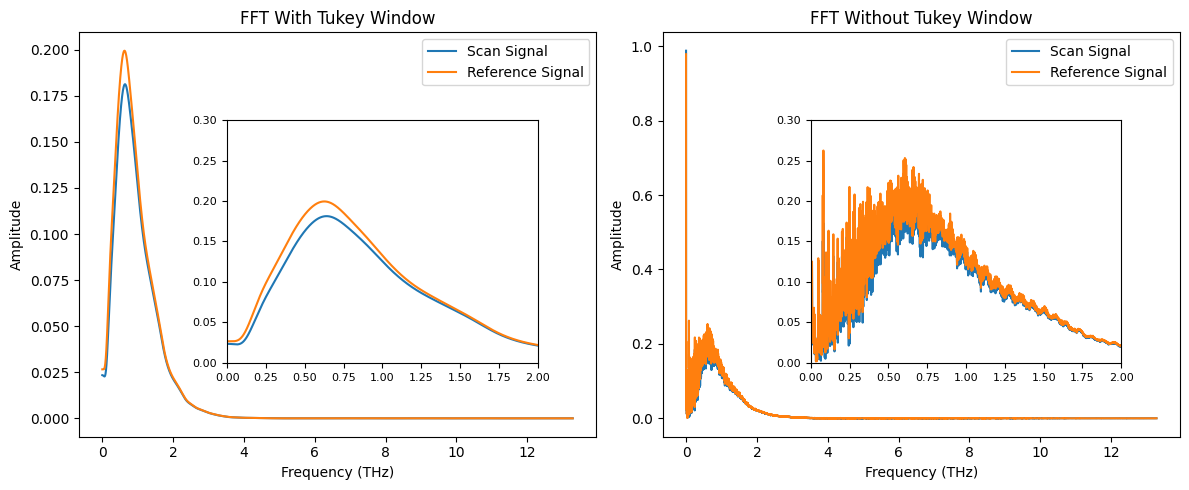

In [19]:
xf_scan = data[1]['scan'][4]['frequencies']
yf_scan = data[1]['scan'][4]['amplitudes']

xf_ref = data[1]['ref'][4]['frequencies']
yf_ref = data[1]['ref'][4]['amplitudes']

xf_scan_no_tukey = data[1]['scan'][4]['frequencies_no_tukey']
yf_scan_no_tukey = data[1]['scan'][4]['amplitudes_no_tukey']

xf_ref_no_tukey = data[1]['ref'][4]['frequencies_no_tukey']
yf_ref_no_tukey = data[1]['ref'][4]['amplitudes_no_tukey']


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(xf_scan, yf_scan, label='Scan Signal')
axs[0].plot(xf_ref, yf_ref, label='Reference Signal')
axs[0].set_xlabel("Frequency (THz)")
axs[0].set_ylabel("Amplitude")
axs[0].set_title("FFT With Tukey Window")



axins = inset_axes(axs[0], width="150%", height="150%", loc='upper right',
                      bbox_to_anchor=(0.5, 0.4, 0.4, 0.4),
                      bbox_transform=axs[0].transAxes)

axins.plot(xf_scan, yf_scan, label='Scan Signal')
axins.plot(xf_ref, yf_ref, label='Reference Signal')
axins.set_xlim(0, 2)
axins.set_ylim(0, 0.3)
axins.tick_params(axis='both', which='major', labelsize=8)
axs[0].legend()


axs[1].plot(xf_scan_no_tukey, yf_scan_no_tukey, label='Scan Signal')
axs[1].plot(xf_ref_no_tukey, yf_ref_no_tukey, label='Reference Signal')
axs[1].set_xlabel("Frequency (THz)")
axs[1].set_ylabel("Amplitude")
axs[1].set_title("FFT Without Tukey Window")


axins = inset_axes(axs[1], width="150%", height="150%", loc='upper right',
                      bbox_to_anchor=(0.5, 0.4, 0.4, 0.4),
                      bbox_transform=axs[1].transAxes)

axins.plot(xf_scan_no_tukey, yf_scan_no_tukey, label='Scan Signal')
axins.plot(xf_ref_no_tukey, yf_ref_no_tukey, label='Reference Signal')
axins.set_xlim(0, 2)
axins.set_ylim(0, 0.3)
axins.tick_params(axis='both', which='major', labelsize=8)
axs[1].legend()

plt.tight_layout()
plt.show()





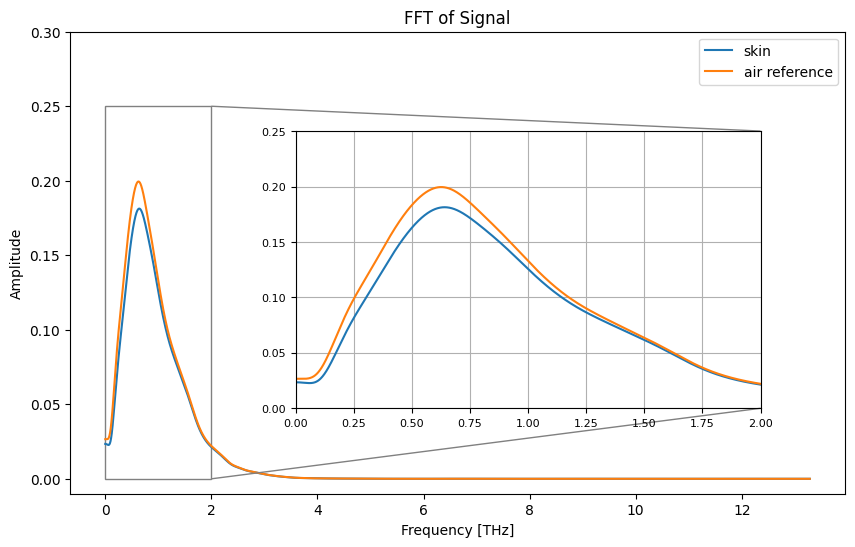

In [80]:
# Plotting FFT

xf_scan = data[1]['scan'][4]['frequencies']
yf_scan = data[1]['scan'][4]['amplitudes']

xf_ref = data[1]['ref'][4]['frequencies']
yf_ref = data[1]['ref'][4]['amplitudes']

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(xf_scan, yf_scan, label='skin')
ax.plot(xf_ref, yf_ref, label='air reference')
ax.set_ylim(-0.01, 0.3)

ax.set_xlabel('Frequency [THz]')
ax.set_ylabel('Amplitude')
ax.set_title('FFT of Signal')

inset_ax = inset_axes(ax, width="150%", height="150%", loc='upper right',
                      bbox_to_anchor=(0.5, 0.4, 0.4, 0.4),
                      bbox_transform=ax.transAxes)

inset_ax.plot(xf_scan, yf_scan, label='Signal')
inset_ax.plot(xf_ref, yf_ref, label='Signal')

# defining the zoom
inset_ax.set_xlim(0, 2)  
inset_ax.set_ylim(0, .25)  

inset_ax.grid(True)

inset_ax.tick_params(axis='both', which='major', labelsize=8)

mark_inset(ax, inset_ax, loc1=1, loc2=4, fc="none", ec="0.5")

ax.legend()

plt.show()

In [81]:
# Normalizing the amplitudes using it's air reference

for d in data:
    for i in range(0, len(d['scan'])):
        scan_amplitudes = d['scan'][i]['amplitudes']
        ref_amplitudes = d['ref'][i]['amplitudes']
        normalized_amplitudes = scan_amplitudes / ref_amplitudes
        d['scan'][i]['normal'] = normalized_amplitudes        

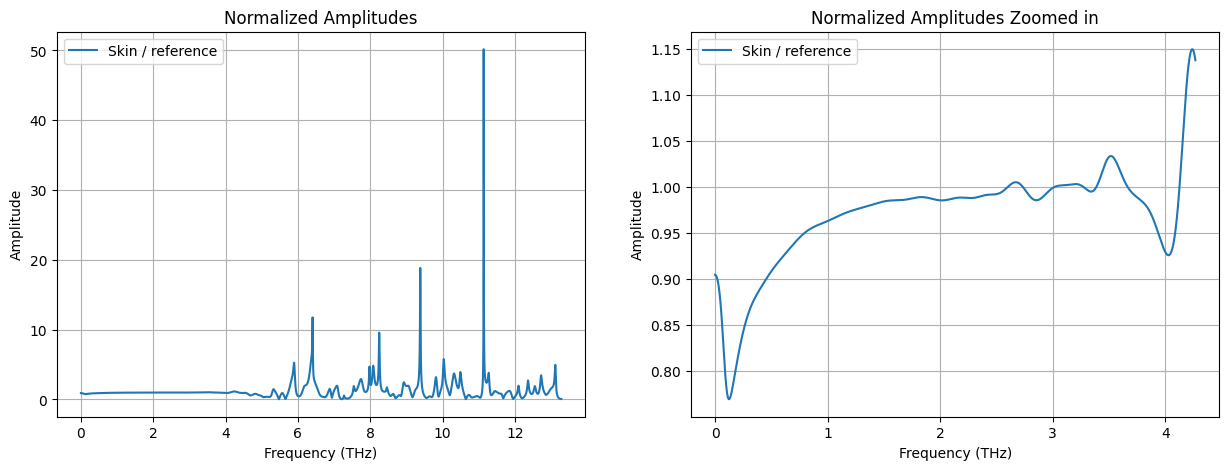

In [82]:
# Plotting Normalized Amplitudes

xf = data[1]['scan'][0]['frequencies']
yf = data[1]['scan'][0]['normal']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(xf, yf, label='Skin / reference')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Normalized Amplitudes")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(xf[0:4000], yf[0:4000], label='Skin / reference')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Normalized Amplitudes Zoomed in")
plt.legend()
plt.grid(True)

plt.show()

As evident by the plot above, the normalized signal becomes very noisy after 3 THz. The reason for this, is that the FFT of the Skin and Reference signals converges to 0 around that frequency (if you look at the previous FFT plot). And at this point there are minor fluctuations around 0 which results in skin having higher magnitude compared to reference. Because the Normalized signal is created as a division between the skin and reference, even small fluctuations can create big amplitudes. 

The reason that the FFT converges to 0 after 3 THz tells us that we don't find much information after this point. The reason for this, is that the teraheartz radiation is absorbed by the material and only the smaller frequencies are reflected back again. (Confirm with Lorenza)

Therefore, it is worthwhile to discard these frequencies as a preprocessing step and continue working without. 

BTW, the dip seen on the right is also something typical and to do with physics. Lorenza gave a good explanation, but need a recap when writing in the report.

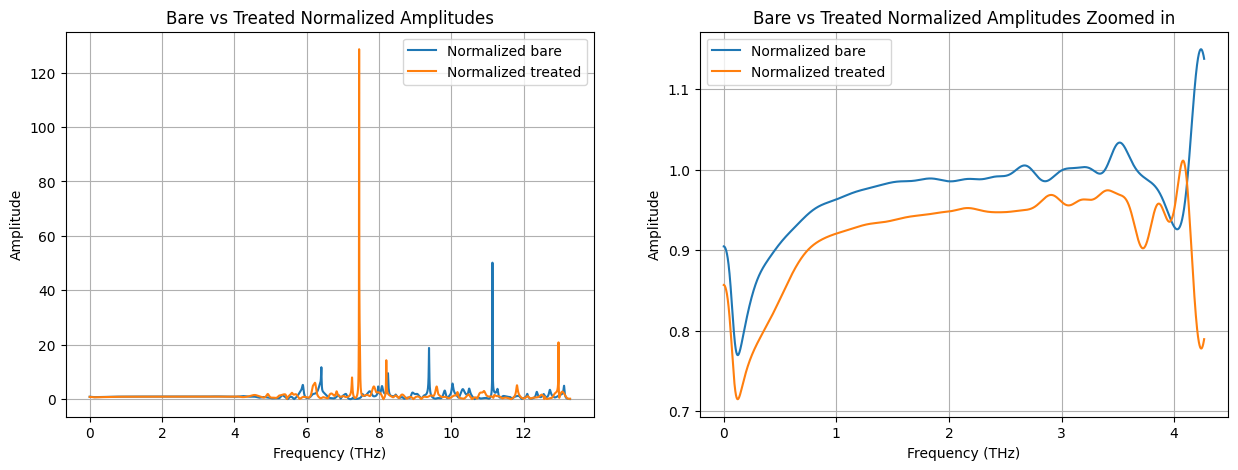

In [83]:
# Plotting the normalized bare pulse vs its corresponding normalized treated pulse
xf_bare = data[1]['scan'][0]['frequencies']
yf_bare = data[1]['scan'][0]['normal']

xf_treated = data[7]['scan'][0]['frequencies']
yf_treated = data[7]['scan'][0]['normal']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(xf_bare, yf_bare, label='Normalized bare')
plt.plot(xf_treated, yf_treated, label='Normalized treated')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Bare vs Treated Normalized Amplitudes")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(xf_bare[0:4000], yf_bare[0:4000], label='Normalized bare')
plt.plot(xf_treated[0:4000], yf_treated[0:4000], label='Normalized treated')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Bare vs Treated Normalized Amplitudes Zoomed in")
plt.legend()
plt.grid(True)

plt.show()

In [84]:
# Creating sample ID as separate field in data dict
for d in data:
    d['sample_id'] = d['samplematrix_fixed'].split()[1]

In [85]:
# Normalizing treated pulse using its corresponding bare pulse  (Is this the correct way?)
bare_data = [d for d in data if 'bare' in d['samplematrix_fixed']]
treated_data = [d for d in data if not 'bare' in d['samplematrix_fixed']]

for i, d in enumerate(treated_data):
    treated = treated_data[i]
    bare = bare_data[i]

    for j in range(0, len(d['scan'])):
        normal_treated = treated['scan'][j]['normal']
        normal_bare = bare['scan'][j]['normal']

        normalized_final = normal_treated / normal_bare

        d['scan'][j]['normal_final'] = normalized_final

data = treated_data

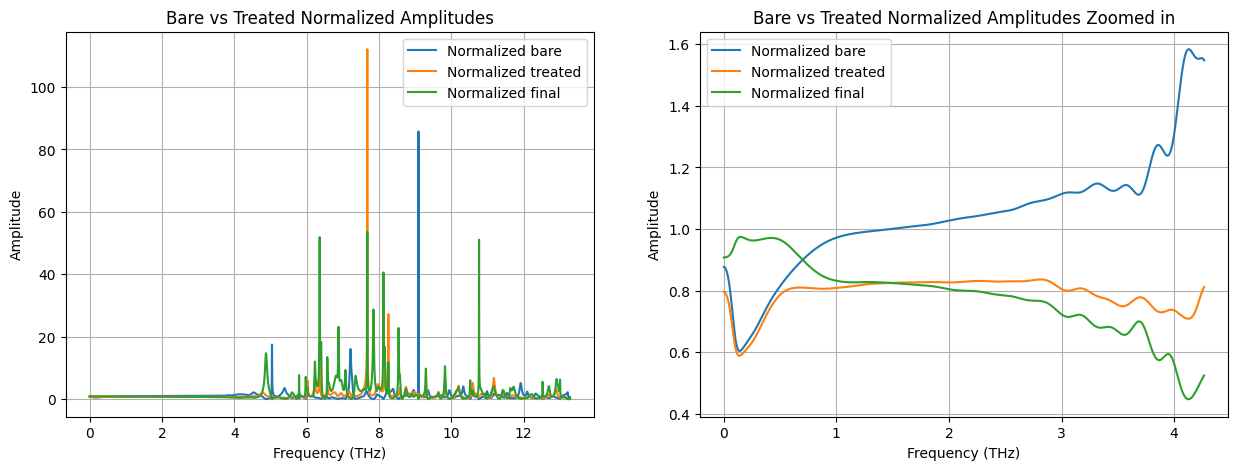

In [88]:
i = 0
j = 0

treated_datapoint = treated_data[i]
corresponding_bare = bare_data[i]

xf_bare = corresponding_bare['scan'][j]['frequencies']
yf_bare = corresponding_bare['scan'][j]['normal']

xf_treated = treated_datapoint['scan'][j]['frequencies']
yf_treated = treated_datapoint['scan'][j]['normal']

xf_final = treated_datapoint['scan'][j]['frequencies']
yf_final = treated_datapoint['scan'][j]['normal_final']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(xf_bare, yf_bare, label='Normalized bare')
plt.plot(xf_treated, yf_treated, label='Normalized treated')
plt.plot(xf_final, yf_final, label='Normalized final')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Bare vs Treated Normalized Amplitudes")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(xf_bare[0:4000], yf_bare[0:4000], label='Normalized bare')
plt.plot(xf_treated[0:4000], yf_treated[0:4000], label='Normalized treated')
plt.plot(xf_final[0:4000], yf_final[0:4000], label='Normalized final')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Bare vs Treated Normalized Amplitudes Zoomed in")
plt.legend()
plt.grid(True)

plt.show()

In [90]:
# Preparing data for PCA and further analysis:
X = []
y = []
y_day = []

for d in data:
    for scan in d['scan']:
        X.append(scan['normal_final'][0:3000]) # Using only the first 3000 entries as it becomes too noisy after. (see above for explanation)
        y.append(d['samplematrix_fixed'].split()[2])
        y_day.append(d['date'].day)

X = np.array(X)

In [91]:
# Exploring class balance

class_counts = {}

for c in y:
    try:
        class_counts[c] += 1
    except KeyError:
        class_counts[c] = 1

print(class_counts)

{'PBS': 220, 'g/PBS': 220}


Completely balanced

# Feature Engineering

List of feature engineering:
- PCA

In [92]:
# PCA
pca = PCA(n_components=None) # Keeping all components

pca.fit(X)

PCA()

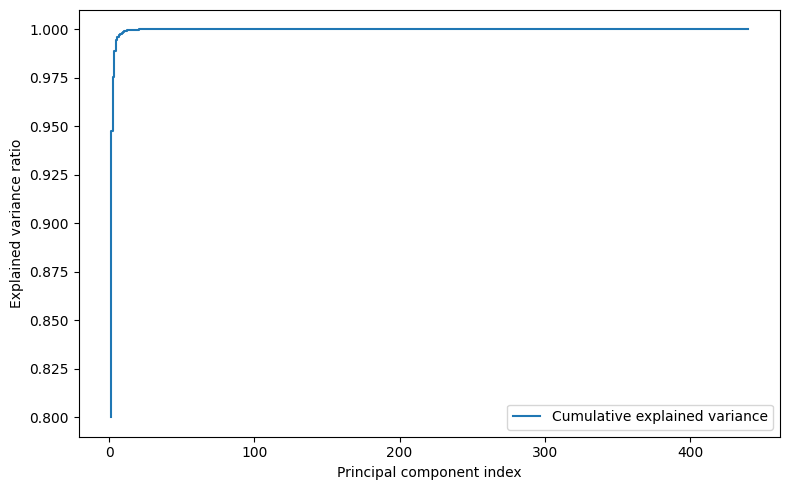

Number of components needed to explain 95.0% of variance is 3
First 2 components explain 94.73864070651685% of variance


In [93]:
# Plotting Cumulative Explained Variance

explained_variance = pca.explained_variance_ratio_

cumulitive_explained_variance = 0
most_important_components = []

required_variance_explained = .95

for i, component in enumerate(explained_variance):
    if cumulitive_explained_variance > required_variance_explained:
        break
    cumulitive_explained_variance += component
    most_important_components.append(pca.components_[i])



plt.figure(figsize=(8, 5))
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print(f"Number of components needed to explain {required_variance_explained*100}% of variance is {len(most_important_components)}")
print(f"First 2 components explain {(explained_variance[0] + explained_variance[1])*100}% of variance")

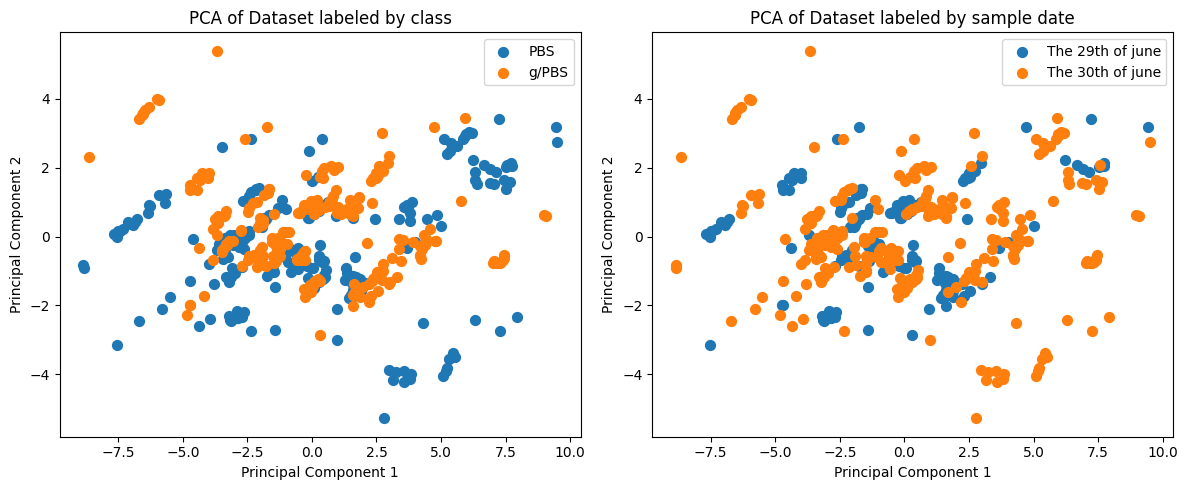

In [94]:
# Plotting data onto first 2 PCs

X_pca = pca.transform(X)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plotting data onto first 2 PCs for different classes
unique_classes = np.unique(y)
for cls in unique_classes:
    ix = [i for i in range(len(y)) if y[i] == cls]
    ax[0].scatter(X_pca[ix, 0], X_pca[ix, 1], label=cls, s=50)

ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')
ax[0].set_title('PCA of Dataset labeled by class')
ax[0].legend()

# Plotting data onto first 2 PCs for different sample dates
unique_classes = np.unique(y_day)
for cls in unique_classes:
    ix = [i for i in range(len(y_day)) if y_day[i] == cls]
    ax[1].scatter(X_pca[ix, 0], X_pca[ix, 1], label=f"The {cls}th of june", s=50)

ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')
ax[1].set_title('PCA of Dataset labeled by sample date')
ax[1].legend()

plt.tight_layout()
plt.show()



In [114]:
from sklearn.preprocessing import LabelEncoder

X_pca_10 = X_pca[:, 0:10] # Keeping first 10 PCs

# Simple split (No k-fold and validation set yet. Later do leave-one-out fold)
# Creating test and training sets
# Have to be multiples of 10 to ensure that all 10 pulses within a datapoint is in the same set
# The reason is that 10 consequtive pulses from same file is likely to be more correlated compared to pulses from other files.
# Therefore if we have pulses from same file in both test and training it can create unrealisticly good performance!
# The term for this is data leakage

label_encoder = LabelEncoder()
label_encoder.fit(y)

y_encoded = label_encoder.transform(y) # class labels as integers

X_train = X_pca_10[:420]
y_train = y_encoded[:420]

X_test = X_pca_10[420:]
y_test = y_encoded[420:]

#The last 20 pulses have 10 pulses from PBS and 10 pulses from g/PBS
#This is important so we can test both classes

In [127]:
# Baseline
from sklearn.metrics import accuracy_score
random_predictions = np.random.choice([0, 1], size=len(y_test))

baseline_accuracy = accuracy_score(y_test, random_predictions)

print(f"The accuracy of the random baseline model on the test set is: {baseline_accuracy:.2f}")

The accuracy of the random baseline model on the test set is: 0.50


In [129]:
# Training support vector machine
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"The accuracy of the SVM classifier on the test set is: {accuracy:.2f}")

The accuracy of the SVM classifier on the test set is: 0.15


The accuracy of the RFC with 10 trees on the test set is: 0.6000
The accuracy of the RFC with 50 trees on the test set is: 0.5000
The accuracy of the RFC with 100 trees on the test set is: 0.3500
The accuracy of the RFC with 200 trees on the test set is: 0.3500
The accuracy of the RFC with 300 trees on the test set is: 0.3000
The accuracy of the RFC with 400 trees on the test set is: 0.3000
The accuracy of the RFC with 500 trees on the test set is: 0.3000


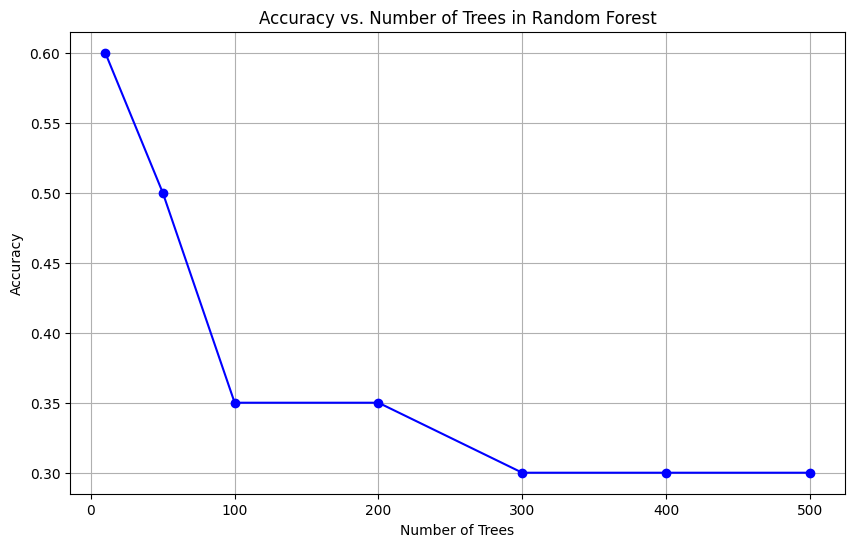

In [141]:
# Training Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

n_estimators_to_test = [10, 50, 100, 200, 300, 400, 500]

accuracies = []

for n_estimators in n_estimators_to_test:
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"The accuracy of the RFC with {n_estimators} trees on the test set is: {accuracy:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_to_test, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. Number of Trees in Random Forest')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()



In [156]:
from sklearn.model_selection import GroupKFold, cross_val_score

# Create group labels for grouped cross-validation to prevent data leakage
groups = np.repeat(np.arange(X_pca_10.shape[0] // 10), 10)

gkf = GroupKFold(n_splits=10)

rf_classifier = RandomForestClassifier(n_estimators=300, random_state=42) #Choosing 300 as that seems to be the point where it converges from above plot

cv_scores = cross_val_score(rf_classifier, X_pca_10, y_encoded, groups=groups, cv=gkf, scoring='accuracy')

# Output the results
print("Cross-Validation Scores:", cv_scores)
print("Average CV Accuracy:", np.mean(cv_scores))


Cross-Validation Scores: [0.54  0.24  0.24  0.2   0.55  0.35  0.725 0.7   0.5   0.5  ]
Average CV Accuracy: 0.4545


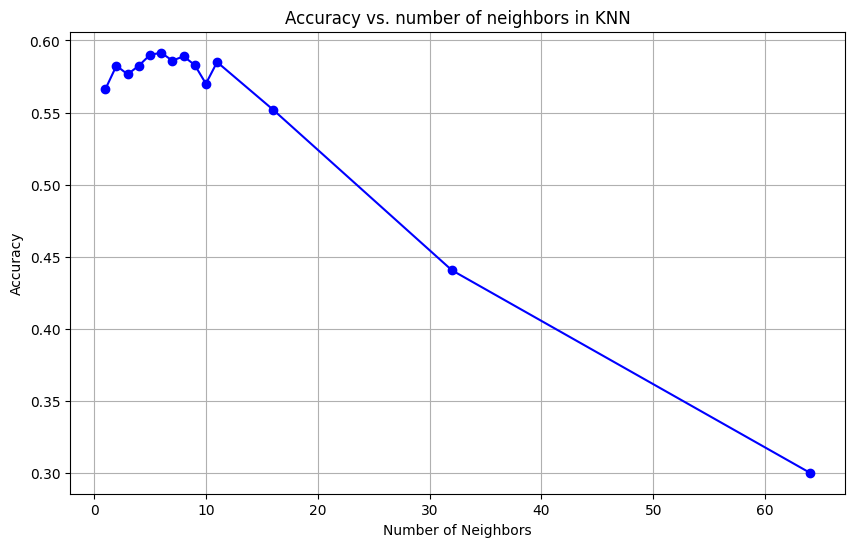

Best obtained accuracy: 0.5915 with knn 6


In [154]:
from sklearn.neighbors import KNeighborsClassifier

knn_to_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 20, 32, 64]

accuracies = []

groups = np.repeat(np.arange(X_pca_10.shape[0] // 10), 10)
gkf = GroupKFold(n_splits=10)

for k in knn_to_test:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_classifier, X_pca_10, y_encoded, groups=groups, cv=gkf, scoring='accuracy')
    accuracies.append(np.mean(cv_scores))

plt.figure(figsize=(10, 6))
plt.plot(knn_to_test, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. number of neighbors in KNN')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

max_accuracy = max(accuracies)
index_of_max = accuracies.index(max_accuracy)
knn_for_max_accuracy = knn_to_test[index_of_max]

print(f"Best obtained accuracy: {max(accuracies)} with knn {knn_for_max_accuracy}")